<a href="https://colab.research.google.com/github/ludigoncalves/bemol-challenge/blob/master/segmentacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visão Geral

Para este desafio, estou considerando a base de dados [Online Retail](https://www.kaggle.com/hellbuoy/online-retail-customer-clustering) devido a natureza dos atributos que podem ser explorados no contexto da Bemol. Por exemplo, usando atributo de localidade (na base nós temos o atributo 'Country') podemos explorar estratégias de Marketing em uma granularidade menor, i.e. por regiões/bairros, ou em uma granularidade maior, como estados (devido a presença da rede Bemol em diversos estados). Outra caracteríística interessante dessa base é que ela possui informação sobre os items comprados pelos consumidores, o que pode ser usado, em termos de estratégia de Marketing novamente, para fazer recomendações de produtos comprados por consumidores pertencentes ao mesmo segmento (cluster) para um consumidor que não os comprou ainda.

A base de dados Online Retail contém transações que ocorrem dentro do período de 01/12/2010 à 09/12/2011 em 38 países diferentes. A companhia vende principalmente presentes exclusivos para todas as ocasições e muitos dos seus clientes são atacadistas. 

# Objetivo

O objetivo deste trabalho consiste em segmentar uma lista de clientes com base em suas transações. Para isto, será utilizada a técnica de análise conhecida como RFM (do inglês Recency, Frequency, and Monetary value). RFM é uma técnica comumente utilizada em Marketing que usa histórico de comportamento de compras para dividir os consumidores em grupos de acordo com as seguintes métricas:
  - Recency (R): tempo decorrido desde a última compra de um dado consumidor. São clientes mais suscetíveis a responder a novas ofertas.
  - Frequency (F): núúmero total de compras do consumidor. Clientes que compraram muito são mais suscetíveis a responder a ofertas que clientes que compraram pouco.
  - Monetary value (M): valor total gasto em compras. Clientes que gastaram valor considerável em compras no passado são mais passíveis de realizarem compras volumosas novamente.

Fontes:
1. [IBM](https://www.ibm.com/support/knowledgecenter/da/SSLVMB_23.0.0/spss/rfm/rfm_intro.xml.html)
2. [Blast Analytics](https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales)

# Metodologia

1. Leitura e Exploração dos Dados
2. Limpeza dos Dados
3. Preparação dos Dados
4. Segmentação
5. Análises

## Estrutura do Notebook

  1. Segmentação de Clientes com RFM
    - Análises
  2. Segmentação de Clientes com K-Means
    - Análises


# Configurações

In [107]:
# Este código foi construído no ambiente de desenvolvimento https://colab.research.google.com/
# Utilizando ambiente Python 3.6.9
# Imports necessários para este desafio

from google.colab import drive # monta ambiente para salvar dados gerados no notebook
import os # seta o caminho no ambiente como padrão 

import pandas as pd # biblioteca para processamento dos dados
import numpy as np # biblioteca de algebra linear

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
# funcao mágica para manter os graficos no notebook e próximos ao código gerador
%matplotlib inline 

# Bibliotecas para a abordagem de Machine Learning
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from time import time

In [2]:
# Versao das bibliotecas utilizadas
!python --version
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Matplotlib: ", mpl.__version__)
print("Seaborn:", sns.__version__)

Python 3.6.9
Pandas: 1.0.5
Numpy: 1.18.5
Matplotlib:  3.2.2
Seaborn: 0.10.1


In [3]:
# Monta o ambiente onde os dados gerados neste notebook serao salvos
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
# Seta o caminho onde os dados serao salvos
def set_path(path):
  os.chdir(path)

In [7]:
set_path('/content/gdrive/My Drive/Colab Notebooks/Bemol_Challenge')
!pwd

/content/gdrive/My Drive/Colab Notebooks/Bemol_Challenge


# Carrega base de dados

In [12]:
def load_data(data_path, sep=',', encoding='UTF-8', index_col=None):
  """
  Funcao para leitura da base de dados
  """
  df = pd.read_csv(data_path, sep=sep, encoding=encoding, index_col=index_col, header=0)

  return df

In [23]:
# Carrega a base
rfm_table = load_data("rfm_table_no_outlier.csv", index_col=['CustomerID'])
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12749,23,5,98.35
12820,45,4,58.20
12821,96,1,19.92
12822,71,2,30.80
12824,30,1,5.04


# Segmentação de Clientes com RFM
  Uma forma amplamente utilizada e simples de criar segmentos com RFM é usando a métrica estatística *quartile*. Notas de 1 a 4 (se o valor está no primeiro quartile, no segundo, terceiro ou quarto) são associadas a Recency, Frequency e Monetary. Um consiste no melhor valor e 4 no pior. O segmento final é calculado combinando as três notas individuais atribuídas a cada métrica (i.e. '111' é um segmento).

## RFM Quartiles


In [24]:
# Encontra Q1, Q2 e Q3 para a tabela rfm
quartiles = rfm_table.quantile(q=[0.25, 0.50, 0.75])
print(quartiles)

      Recency  Frequency  Monetary
0.25     25.0        1.0   15.5625
0.50     70.0        2.0   35.1000
0.75    167.0        4.0   75.3725


In [25]:
# Para facilitar o acesso
quartiles = quartiles.to_dict()

## Criação dos Segmentos <br>
  Devido ao fato de em Recency um bom valor ser um valor baixo (quanto mais recente sua última compra tiver sido, menor é o valor) 
e o mesmo não valer para Frequency e Monetary (onde valores altos sãos os melhores valores), duas funções diferentes de criação de segmentos
precisam ser criadas.

In [26]:
# Funcoes para atribuicao de notas recency, frequency e monetary
def r_score(x, m, d):
  """ 
  Score Attribution Function
  Params:
    x = value,
    m = metric (recency)
    d = quartiles dictionary    
  """
  if x <= d[m][0.25]:
    return 1
  elif x <= d[m][0.50]:
    return 2
  elif x <= d[m][0.75]:
    return 3
  else:
    return 4

def fm_score(x, m, d):
  """ 
  Score Attribution Function
  Params:
    x = value,
    m = metric (frequency or monetary)
    d = quartiles dictionary    
  """
  if x <= d[m][0.25]:
    return 4
  elif x <= d[m][0.50]:
    return 3
  elif x <= d[m][0.75]:
    return 2
  else:
    return 1

In [27]:
# Cria tabela rfm com os segmentos para dados sem outliers
rfm_table['R_Score'] = rfm_table['Recency'].apply(r_score, args=('Recency', quartiles,))
rfm_table['F_Score'] = rfm_table['Frequency'].apply(fm_score, args=('Frequency', quartiles,))
rfm_table['M_Score'] = rfm_table['Monetary'].apply(fm_score, args=('Monetary', quartiles,))

rfm_table.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerID,,,,,,
12749,23,5,98.35,1,1,1
12820,45,4,58.20,2,2,2
12821,96,1,19.92,3,4,3
12822,71,2,30.80,3,3,3
12824,30,1,5.04,2,4,4


In [28]:
# Com as notas calculadas, os segmentos sao montados, combinando R_Score, F_Score e M_Score para a tabela sem outliers
rfm_table['RFM'] = rfm_table['R_Score'].map(str) \
                + rfm_table['F_Score'].map(str) \
                + rfm_table['M_Score'].map(str)
rfm_table.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM
CustomerID,,,,,,,
12749,23,5,98.35,1,1,1,111
12820,45,4,58.20,2,2,2,222
12821,96,1,19.92,3,4,3,343
12822,71,2,30.80,3,3,3,333
12824,30,1,5.04,2,4,4,244


## Salva a Tabela RFM para consumo

In [29]:
# Salva tabela final sem outliers
rfm_table.to_csv('customer_segment.csv')

## Análises com RFM

In [30]:
rfm_table.shape

(3234, 7)

Segundo a fonte [Blast Analytics](https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales), a tabela a seguir apresenta os principais segmentos RFM e sugestões de atuação em nível de Marketing.

| Segmentos | RFM | Descrição | Ações de Marketing |
|-----------|-----|-----------|--------------------|
| Melhores Clientes | 111 | Comprou mais recentemente, <br> com mais frequência e gastou mais | Sem incentivo de preços, novos produtos <br> e programas de lealdade |
| Clientes Leais | x1x | Compra frequentemente | Usa R e M pra repensar estratégias |
| Grandes Compradores | xx1 | Gastam mais | Mostrar itens mais caros |
| Quase perdido | 311 | Não compra há algum tempo, <br> mas comprou com frequencia e <br> gastou muito | Incentivo com preços agressivos |
| Cliente perdido | 411 |  Não compra há muito tempo, <br> mas comprou com frequencia e <br> gastou muito | Incentivo com preçços agressivos |
| Clientes baratos perdidos | 444 | Comprou há muito tempo, <br>pouco e gastou pouco também | Não perca muito tempo tentando readquiri-lo |

Com base nesta tabela, criaremos uma coluna 'Segment' para a realização de algumas análises. Mais segmentos podem ser análisados dependendo da necessidade da equipe de Marketing.


In [31]:
# Extraindo lista de clientes contidos nos segmentos melhores clientes, quase perdido, cliente perdido e clientes baratos perdidos
best = rfm_table.loc[rfm_table['RFM'] == '111'].index
almost_lost = rfm_table.loc[rfm_table['RFM'] == '311'].index
lost = rfm_table.loc[rfm_table['RFM'] == '411'].index
lost_cheap = rfm_table.loc[rfm_table['RFM'] == '444'].index

In [32]:
# Atribuindo os segmentos a tabela rfm
rfm_table['Segment'] = np.array([np.nan for i in range(rfm_table.shape[0])])

rfm_table.loc[rfm_table.index.isin(best), 'Segment'] = "Melhores Clientes"
rfm_table.loc[rfm_table.index.isin(almost_lost), 'Segment'] = "Quase Perdido"
rfm_table.loc[rfm_table.index.isin(lost), 'Segment'] = "Cliente Perdido"
rfm_table.loc[rfm_table.index.isin(lost_cheap), 'Segment'] = "Clientes Baratos Perdidos"

In [33]:
# Atribui segmento 'Loyal Customers' aos individuos com a melhor nota em frequency
loyal_temp = rfm_table.loc[rfm_table['F_Score'] == 1].index

# Filtra os clientes que ja apareceram em outros segmentos
loyal = loyal_temp[~loyal_temp.isin(best)]
loyal = loyal[~loyal.isin(almost_lost)]
loyal = loyal[~loyal.isin(lost)]

rfm_table.loc[rfm_table.index.isin(loyal), 'Segment'] = "Clientes Leais"


# Atribui segmento 'Big Spenders' aos individuos com a melhor nota em monetary
big_spenders_temp = rfm_table.loc[rfm_table['M_Score'] == 1].index

big_spenders = big_spenders_temp[~big_spenders_temp.isin(best)]
big_spenders = big_spenders[~big_spenders.isin(almost_lost)]
big_spenders = big_spenders[~big_spenders.isin(lost)]

rfm_table.loc[rfm_table.index.isin(big_spenders), 'Segment'] = "Grandes Compradores"

In [34]:
# Preenche quem ficou sem segmento
rfm_table['Segment'] = rfm_table['Segment'].fillna("Outros")

In [35]:
# Verificacao dos valores
rfm_table['Segment'].unique()

array(['Melhores Clientes', 'Outros', 'Grandes Compradores',
       'Quase Perdido', 'Clientes Baratos Perdidos', 'Clientes Leais',
       'Cliente Perdido'], dtype=object)

Com os principais segmentos definidos, podemos plotar alguns gráficos pra analisarmos a distribuição dos segmentos

In [36]:
# Construcao de ados de representacao de cada segmento
plot_data = rfm_table.groupby(by=['Segment'], as_index=False)['RFM'].count().rename(columns={'RFM': 'Count'})
plot_data = plot_data.sort_values(by='Count', ascending=False).reset_index(drop=True)
plot_data['Percentage'] = plot_data['Count'].apply(lambda x: x/rfm_table.shape[0])

In [37]:
# Construcao de dados de recency medio por segmento
plot_data_r = rfm_table.groupby(by=['Segment'], as_index=False)['Recency'].mean().rename(columns={'Recency': 'AVG_Recency'})
plot_data_r['AVG_Recency'] = plot_data_r['AVG_Recency'].round(2)
plot_data_r = plot_data_r.sort_values(by='AVG_Recency', ascending=False).reset_index(drop=True)

In [38]:
# Construcao de dados de frequency medio por segmento
plot_data_f = rfm_table.groupby(by=['Segment'], as_index=False)['Frequency'].mean().rename(columns={'Frequency': 'AVG_Frequency'})
plot_data_f['AVG_Frequency'] = plot_data_f['AVG_Frequency'].round(2)
plot_data_f = plot_data_f.sort_values(by='AVG_Frequency', ascending=False).reset_index(drop=True)

In [39]:
# Construcao de dados de monetary medio por segmento
plot_data_m = rfm_table.groupby(by=['Segment'], as_index=False)['Monetary'].mean().rename(columns={'Monetary': 'AVG_Monetary'})
plot_data_m['AVG_Monetary'] = plot_data_m['AVG_Monetary'].round(2)
plot_data_m = plot_data_m.sort_values(by='AVG_Monetary', ascending=False).reset_index(drop=True)

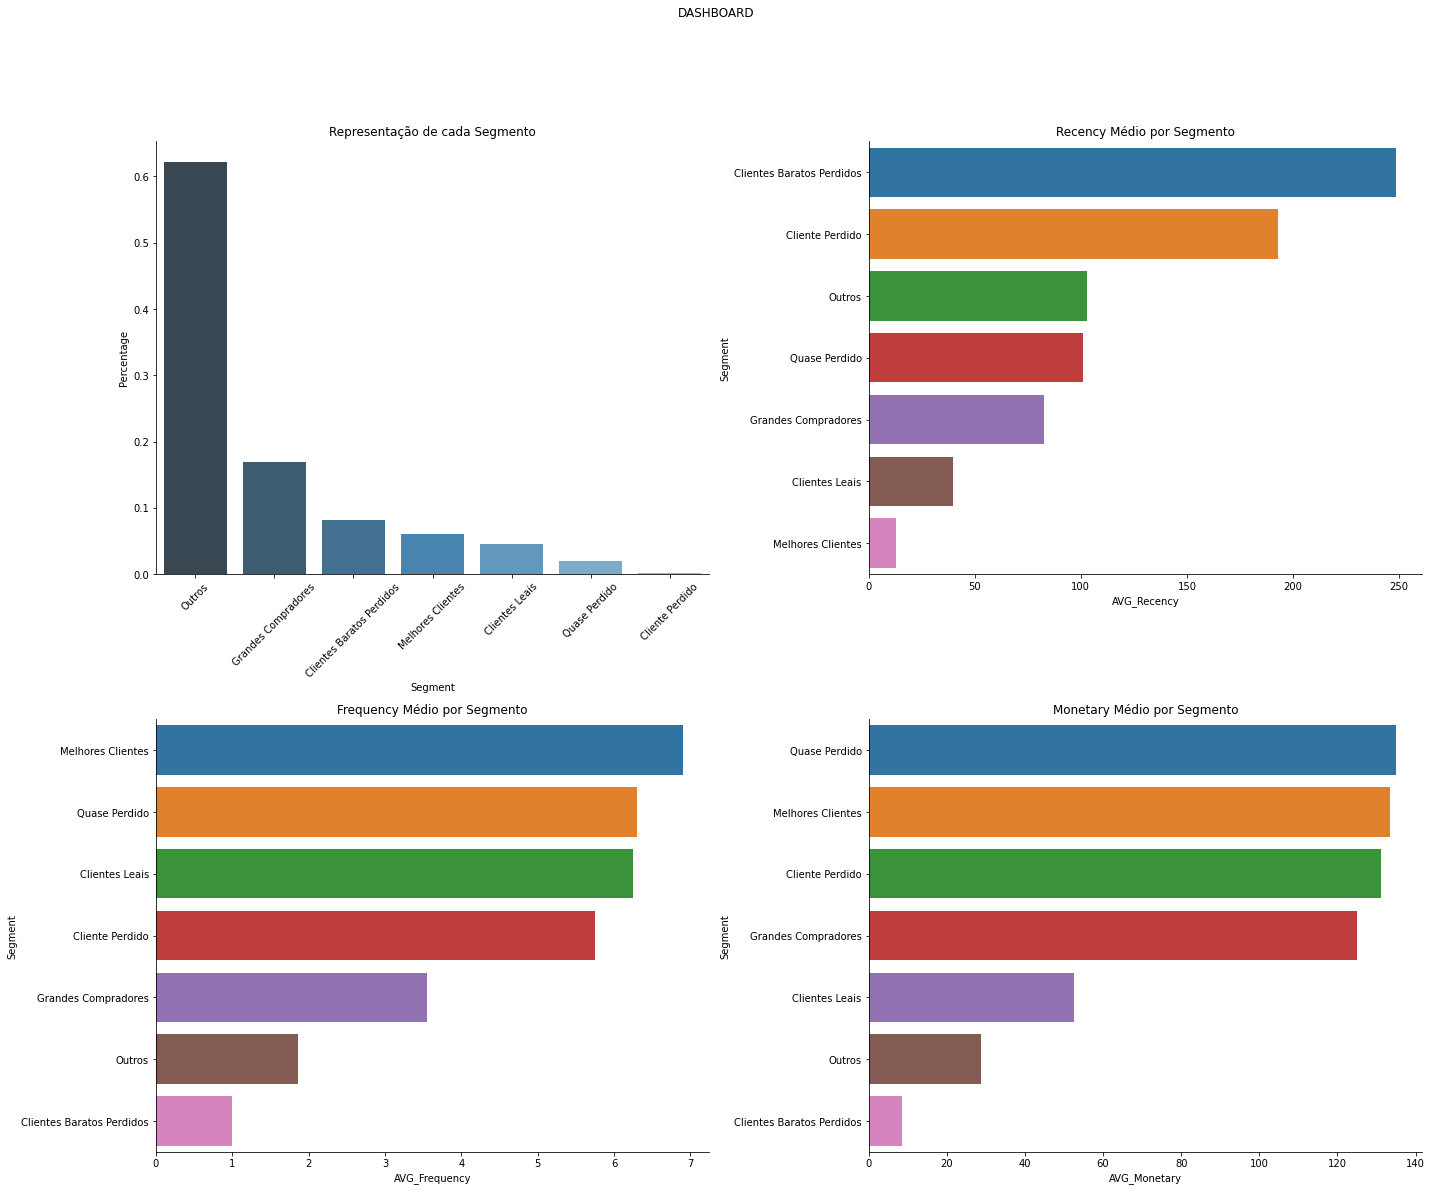

In [165]:
# Dashboard
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(2, 2, 1)
ax1.title.set_text('Representação de cada Segmento')
ax1.set_xticklabels(plot_data['Segment'], rotation=45)
sns.barplot(data=plot_data, x='Segment', y='Percentage', palette='Blues_d')

ax2 = fig.add_subplot(2, 2, 2)
ax2.title.set_text('Recency Médio por Segmento')
ax2.set_xlabel('Average Recency (days)')
ax2 = sns.barplot(data=plot_data_r, x='AVG_Recency', y='Segment')
#ax.set_title('Average Recency per Segment')

ax3 = fig.add_subplot(2, 2, 3)
ax3.title.set_text('Frequency Médio por Segmento')
ax3.set_xlabel('Average Frequency')
ax3 = sns.barplot(data=plot_data_f, x='AVG_Frequency', y='Segment')

ax4 = fig.add_subplot(2, 2, 4)
ax4.title.set_text('Monetary Médio por Segmento')
ax4.set_xlabel('Average Monetary')
ax4 = sns.barplot(data=plot_data_m, x='AVG_Monetary', y='Segment')

sns.despine()

fig.tight_layout()                                                    
fig.suptitle('DASHBOARD', y=1.1)
plt.show()

Observando os gráficos conseguimos obervar que: <br>
 1. Devido a grande quantidade de clientes fora das classes principais desenhadas pelos especialistas no geral, aqui representadas em 'Outros', se faz necessário encontrar outra abordagem para analisar este grupo, que por restrições de tempo não será explorado.
 2. Outro ponto interessante é que compradores leais, apesar da alta frequência de compra e também de serem compradores recentes, não gastam muito em suas compras. Um ponto que poderia ser analisado seria o perfil de compra desses compradores, como categoria de produtos (dado que se tem acesso a este dado) entre outros, que proporcione dados para ações de engajamento desses compradores em compras maiores.
 3. Um grupo que também me chamou atenção foi o de 'Quase Perdido'. Apesar de normalmente ser classificado como um grupo que não compra há algum tempo, ele não está entre os piores nessa classificação, mas se encontra nos top compradores mais frequentes e que mais gastam, demandando assim uma certa atenção por parte do Marketing, pois acredito que sejam clientes fáceis de voltar a cativar.

# Segmentação de Clientes com K-Means

O K-Means é um popular algoritmo não supervisionado de agrupamento que em geral é rápido e eficiente. O seu funcionamento consiste em:
 1. Inicializa o valor de K (número de agrupamentos), pontos estes conhecidos como centróides.
 2. A distância entre os dados da base são calculadas em relação aos centróides. Ao final as coordenadas do centróide são recalculadas.
 3. O passo 2 é repetido até que os agrupamentos sejam encontrados.

Para abordagens de aprendizagem de máquina, no geral, é necessário que se faça uma normalização dos dados para que eles tenham escalas comparáveis e não atrapalhem o desempenho do algoritmo.

Dentre as diversas técnicas que podem ser utilizadas para este fim, a mais popular é a *Standardisation*.

In [97]:
# Normalizando os atributos

rfm_scaled = rfm_table[['Recency', 'Frequency', 'Monetary']]

# Inicia o metodo
scaler = StandardScaler()

# Normaliza
print(rfm_scaled.shape)
rfm_scaled = scaler.fit_transform(rfm_scaled)
print(rfm_scaled.shape)

(3234, 3)
(3234, 3)


In [98]:
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_scaled.head()

,Recency,Frequency,Monetary
0,-0.856812,1.113319,0.894787
1,-0.621945,0.635168,0.103228
2,-0.077480,-0.799283,-0.651464
3,-0.344375,-0.321133,-0.436964
4,-0.782081,-0.799283,-0.944823


Um ponto muito importante no algoritmo K-Means é a escolha do número de agrupamentos ideal. Para isso, existem algumas técnicas conhecidas como a Elbow Curve e a Silhouette Score.

* Elbow Curve <br>
 Consiste em uma análise visual da inércia do modelo em função do número de agrupamentos, onde em geral o melhor K se enconnta em um ponto de inflexão que lembra o formato de um cotovelo (*elbow*)

In [99]:
# Elbow Curve

start = time()
inertia = []
k_range = [2, 3, 4, 5, 6, 7, 8]
for cluster in k_range:
    kmeans = KMeans(n_clusters=cluster, max_iter=100)
    kmeans.fit(rfm_scaled)
    
    inertia.append(kmeans.inertia_)
    print("K: {0} \t Inertia: {1}".format(cluster, round(kmeans.inertia_, 2)))

end = time()

print('Time: {0} min'.format(round((end-start)/60, 2)))

K: 2 	 Inertia: 5534.71
K: 3 	 Inertia: 3479.08
K: 4 	 Inertia: 2838.22
K: 5 	 Inertia: 2296.2
K: 6 	 Inertia: 1989.89
K: 7 	 Inertia: 1772.37
K: 8 	 Inertia: 1597.73
Time: 0.02 min


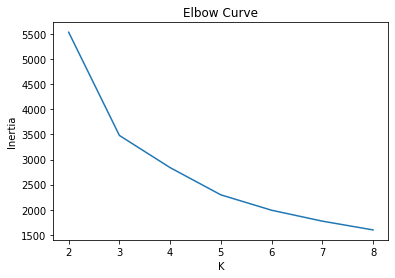

In [100]:
# Prepara os dados para visualizacao
df_inertia = pd.DataFrame(np.array(k_range), columns=['K'])
df_inertia['Inertia'] = np.array(inertia).round(2)
df_inertia.head()

# Visualizacao da curva
plt.plot(df_inertia['K'], df_inertia['Inertia'])
plt.title('Elbow Curve')
plt.xlabel('K')
plt.ylabel('Inertia')

plt.show()

* Silhouette Score <br>
 A Silhoutte score consiste em uma técnica mais precisa de escolha do número de agrupamentos (mas também computacionalmente mais cara). O coeficiente é encontrado através do cálculo:
 $$
 silhouette\_score = \frac{b - a}{max(a, b)},
 $$
onde $a$ é a distância média para outras instâncias no mesmo agrupamento (*mean intra-cluster distance*) e $b$ é a distância média para instância do agrupamento mais próximo, que minimiza $b$, excluindo o próprio agrupamento.

In [101]:
# Silhouette Score
start = time()

k_range = [2, 3, 4, 5, 6, 7, 8]
silhouettes = []

for cluster in k_range:
    
    # Instancia kmeans
    kmeans = KMeans(n_clusters=cluster, max_iter=100)
    kmeans.fit(rfm_scaled)
    
    silhouette = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouettes.append(silhouette)

    print("K: {0} \t Silhouette score: {1}".format(cluster, silhouette))

end = time()

print('Time: {0} min'.format(round((end-start)/60, 2)))

K: 2 	 Silhouette score: 0.43168902082726035
K: 3 	 Silhouette score: 0.42248656312160504
K: 4 	 Silhouette score: 0.3964912526122577
K: 5 	 Silhouette score: 0.3894468167925258
K: 6 	 Silhouette score: 0.3577928529995043
K: 7 	 Silhouette score: 0.340265364857745
K: 8 	 Silhouette score: 0.35023500514461936
Time: 0.05 min


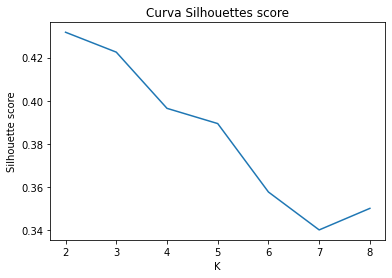

In [102]:
# Prepara os dados para visualizacao
df_silho = pd.DataFrame(np.array(k_range), columns=['K'])
df_silho['Silhouettes'] = np.array(silhouettes)
df_silho.head()

# Visualizacao dos scores
plt.plot(df_silho['K'], df_silho['Silhouettes'])
plt.title('Curva Silhouettes score')
plt.xlabel('K')
plt.ylabel('Silhouette score')

plt.show()

Olhando para a curva Elbow o $k$ ideal poderia ser e ou $5$, mas pela natureza da ruptura, acredito que o $3$ seria o ideal. Já com a silhouette, que é uma abordagem mais precisa (segundo a literatura), $k$ igual a $5$ se faz ideal, o que também era uma das alternativas pela análise da curva Elbow. Assim, a segmentação com o K-Means seráá feita com $5$ agrupamentos.

In [103]:
start = time()

# Modelo de segmentacao 5-Means
kmeans = KMeans(n_clusters=5, max_iter=100)
kmeans.fit(rfm_scaled)

end = time()

print('Time: {0} min'.format(round((end-start)/60, 2)))

Time: 0.0 min


In [104]:
rfm_table['Cluster'] = kmeans.labels_
rfm_table.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM,Segment,Cluster
CustomerID,,,,,,,,,
12749,23,5,98.35,1,1,1,111,Melhores Clientes,1
12820,45,4,58.20,2,2,2,222,Outros,1
12821,96,1,19.92,3,4,3,343,Outros,2
12822,71,2,30.80,3,3,3,333,Outros,2
12824,30,1,5.04,2,4,4,244,Outros,2


In [139]:
# Construcao de dados para analise agrupamento vs. segmento para o agrupamento 0
grupo_0 = rfm_table[rfm_table['Cluster'] == 0] 
plot_0 = grupo_0.groupby(by=['Segment'], as_index=False)['Cluster'].count().rename(columns={'Cluster': 'Count'})
plot_0 = plot_0.sort_values(by='Count', ascending=False).reset_index(drop=True)
plot_0['Percentage'] = plot_0['Count'].apply(lambda x: x/grupo_0.shape[0])

In [142]:
# Construcao de dados para analise agrupamento vs. segmento para o agrupamento 1
grupo_1 = rfm_table[rfm_table['Cluster'] == 1] 
plot_1 = grupo_1.groupby(by=['Segment'], as_index=False)['Cluster'].count().rename(columns={'Cluster': 'Count'})
plot_1 = plot_1.sort_values(by='Count', ascending=False).reset_index(drop=True)
plot_1['Percentage'] = plot_1['Count'].apply(lambda x: x/grupo_1.shape[0])

In [144]:
# Construcao de dados para analise agrupamento vs. segmento para o agrupamento 2
grupo_2 = rfm_table[rfm_table['Cluster'] == 2] 
plot_2 = grupo_2.groupby(by=['Segment'], as_index=False)['Cluster'].count().rename(columns={'Cluster': 'Count'})
plot_2 = plot_2.sort_values(by='Count', ascending=False).reset_index(drop=True)
plot_2['Percentage'] = plot_2['Count'].apply(lambda x: x/grupo_2.shape[0])

In [146]:
# Construcao de dados para analise agrupamento vs. segmento para o agrupamento 3
grupo_3 = rfm_table[rfm_table['Cluster'] == 3] 
plot_3 = grupo_3.groupby(by=['Segment'], as_index=False)['Cluster'].count().rename(columns={'Cluster': 'Count'})
plot_3 = plot_3.sort_values(by='Count', ascending=False).reset_index(drop=True)
plot_3['Percentage'] = plot_3['Count'].apply(lambda x: x/grupo_3.shape[0])

In [148]:
# Construcao de dados para analise agrupamento vs. segmento para o agrupamento 4
grupo_4 = rfm_table[rfm_table['Cluster'] == 4] 
plot_4 = grupo_4.groupby(by=['Segment'], as_index=False)['Cluster'].count().rename(columns={'Cluster': 'Count'})
plot_4 = plot_4.sort_values(by='Count', ascending=False).reset_index(drop=True)
plot_4['Percentage'] = plot_4['Count'].apply(lambda x: x/grupo_4.shape[0])

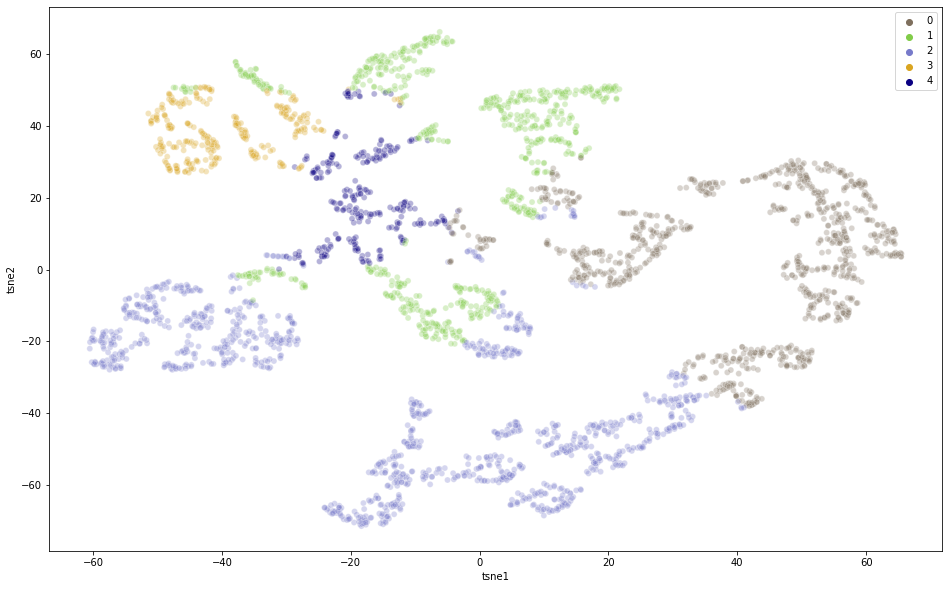

In [106]:
# Visualizando os agrupamentos com o tsne
colors = ["#7e6f5d", "#81cc49","#777aca","#daa520","#0a0082"]

X = rfm_scaled.copy()

X_embedded = TSNE(n_components=2).fit_transform(X)

df_subset = pd.DataFrame()
df_subset['tsne1'] = X_embedded[:,0]
df_subset['tsne2'] = X_embedded[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue=kmeans.labels_,
    palette=sns.color_palette(colors[:6]),
    data=df_subset,
    legend="full",
    alpha=0.3
)

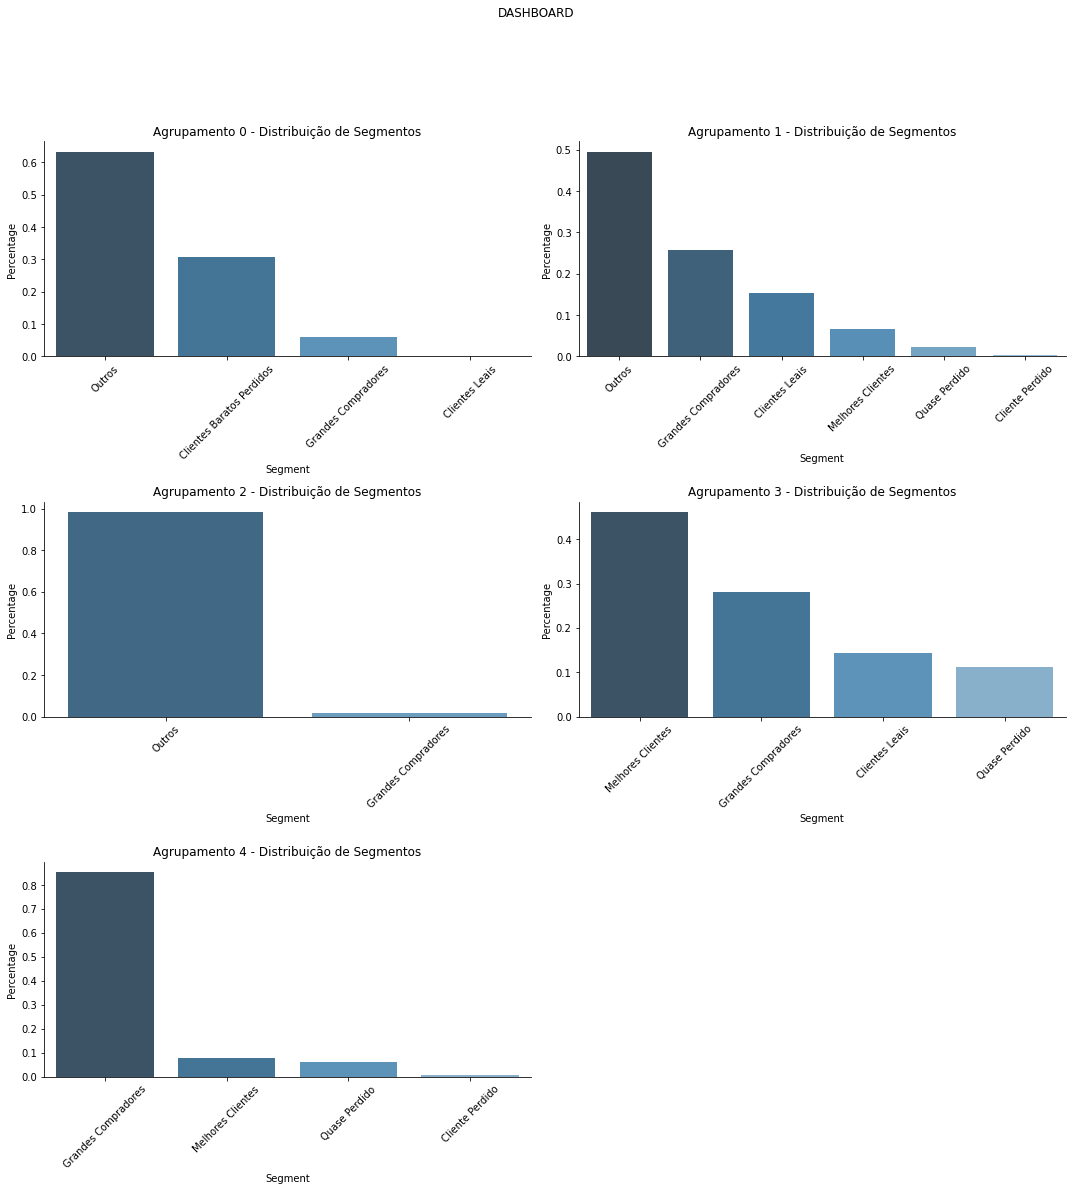

In [161]:
# Dashboard
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(3, 2, 1)
ax1.title.set_text('Agrupamento 0 - Distribuição de Segmentos')
ax1.set_xticklabels(plot_0['Segment'], rotation=45)
sns.barplot(data=plot_0, x='Segment', y='Percentage', palette='Blues_d')

ax2 = fig.add_subplot(3, 2, 2)
ax2.title.set_text('Agrupamento 1 - Distribuição de Segmentos')
ax2.set_xticklabels(plot_1['Segment'], rotation=45)
sns.barplot(data=plot_1, x='Segment', y='Percentage', palette='Blues_d')

ax3 = fig.add_subplot(3, 2, 3)
ax3.title.set_text('Agrupamento 2 - Distribuição de Segmentos')
ax3.set_xticklabels(plot_2['Segment'], rotation=45)
sns.barplot(data=plot_2, x='Segment', y='Percentage', palette='Blues_d')

ax4 = fig.add_subplot(3, 2, 4)
ax4.title.set_text('Agrupamento 3 - Distribuição de Segmentos')
ax4.set_xticklabels(plot_3['Segment'], rotation=45)
sns.barplot(data=plot_3, x='Segment', y='Percentage', palette='Blues_d')

ax4 = fig.add_subplot(3, 2, 5)
ax4.title.set_text('Agrupamento 4 - Distribuição de Segmentos')
ax4.set_xticklabels(plot_4['Segment'], rotation=45)
sns.barplot(data=plot_4, x='Segment', y='Percentage', palette='Blues_d')

sns.despine()

fig.tight_layout()                                                    
fig.suptitle('DASHBOARD', y=1.1)
plt.show()

## Análises
* No agrupamento 3 podemos observar que se encontram os clientes mais valiosos para a empresa. A presença do cliente 'Quase Perdido' vai na mesma linha do achado nas análises da classificação com RFM, onde apesar de pela teoria do RFM ser um cliente não tão bom, possui boas métricas, o diferenciando muito das classes de clientes que merecem pouca atenção.
* A distribuição da classe 'Outros' em três agrupamentos diferentes, endossa a hipótese criada, a partir da análise do RFM, de que somente a classificação desses grandes segmentos sugeridos pela literatura não seja suficiente para caracterizar esse grupo grande de clientes que não temos intuição ('Outros').

# Salva Tabela Final

In [167]:
# Salva tabela final sem outliers
rfm_table.to_csv('customer_segment.csv')